## scMKL workshop
Here, we will run scMKL with a 10x Multiome (scRNA-seq and scATAC-seq) small lymphocytic lymphoma (SLL) dataset.

In [1]:
import scmkl
import numpy as np
import scanpy as sc
from muon import atac as ac
from scipy.sparse import load_npz

/home/exacloud/gscratch/CEDAR/vangordi/Miniconda3/envs/new_scmkl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading in data
data_dir = '/home/groups/CEDAR/scMKL/data/lymphoma/'
x_fp = data_dir + 'lymphoma_{}_scipy.npz'
vars_fp = data_dir + 'lymphoma_{}_feature_names.npy'
labs_fp = data_dir + 'lymphoma_celltype_labels.npy'

# RNA data
rna_x = load_npz(x_fp.format('RNA'))
rna_var = np.load(vars_fp.format('RNA'), allow_pickle=True)

# ATAC data
atac_x = load_npz(x_fp.format('ATAC'))
atac_var = np.load(vars_fp.format('ATAC'), allow_pickle=True)

# Cell labels
labs = np.load(labs_fp, allow_pickle=True)

## Getting a gene grouping
scMKL requires grouping dictionaries to calculate ***Z*** matrices. To find possible libraries containing gene sets for our classification task, we can use the `scmkl.find_candidates()` function.

In [3]:
# Terms that we want in group names
terms = [
    'lymph node', 'b cell', 't cell', 
    'dendritic', 'fibroblast', 'monocyte', 
    'stromal', 'tumor', 'cancer', 'lymph'
    ]

# Terms we want to avoid
blist = [
    'progenitor', 'umbilical', 'tonsil', 
    'lung', 'intestine', 'spleen', 'bile',
    'liver', 'epithel', 'stem', 'pancreas',
    'breast', 'skin', 'stomach', 'colo', 
    'fetal', 'bone', 'heart', 'endothel'
    ]

scmkl.find_candidates(organism='human',
                      key_terms=terms,
                      blacklist=blist)

,Library,No. Gene Sets,No. Key Terms Matching,No. Blacklist Matching
0,Azimuth_2023,1241,189,811
1,Azimuth_Cell_Types_2021,341,48,7
2,Cancer_Cell_Line_Encyclopedia,967,178,540
3,CellMarker_2024,1134,429,627
4,CellMarker_Augmented_2021,1096,316,601
5,GO_Biological_Process_2025,5341,251,256
6,GO_Cellular_Component_2025,466,3,0
7,GO_Molecular_Function_2025,1174,7,7
8,KEGG_2021_Human,320,19,16
9,MSigDB_Hallmark_2020,50,0,3


Now that we have decided on a gene set library, we will pull and filter it with `scmkl.get_gene_groupings()`.

**NOTE:** Including `key_terms` or `blist` will filter output groups to only groups that contain one or more elements from `key_terms` and not `blist`. Additionally, including a list of gene names (from your dataset) will filter out groups that do not contain at least two genes from the input gene names as these groups would be filtered out in later steps of the workflow anyways. If you want the entire library only specify `lib_name` and `organism`.

In [4]:
gene_groups = scmkl.get_gene_groupings(lib_name='CellMarker_2024', 
                                       organism='human',
                                       key_terms=terms,
                                       blacklist=blist, 
                                       genes=rna_var)

print(f"There are {len(gene_groups)} groups in `gene_groups`")

There are 222 groups in `gene_groups`


## Creating a region grouping

While there are many ways to group regions, the fastest is to group regions by inferrered promotor of genes from gene groupings. To do this, we need a GTF file. If your features are aligned to GRCh38/hg38, the 'Homo_sapiens.GRCh38.114.chr.gtf.gz' GTF will work.

In [5]:
# Reading in GTF and filtering to protein coding genes
gtf_fp = data_dir + '../gencode.v32.primary_assembly.annotation.gtf.gz'
gtf = scmkl.read_gtf(gtf_fp, filter_to_coding=True)

# Using gene groupings and regions to create grouping dictionary
region_groups = scmkl.get_region_groupings(gtf, gene_groups, feature_names=atac_var, len_up=100000, len_down=100000)

print(f"There are {len(region_groups)} groups in `region_groups`")

There are 222 groups in `region_groups`


In [6]:
avg_regions = np.median([len(feats) for _, feats in region_groups.items()])

print(f"Median number of regions per group: {avg_regions}")

Median number of regions per group: 185.0


## Creating scMKL formatted AnnData object
There are two functions for creating AnnData objects. `scmkl.create_adata()` takes a single-cell dataset separated into the matrix, feature names, and cell labels. `scmkl.format_adata()` takes an existing AnnData object and adds the required variables to run scMKL. There are different parameters depending on if the input data matrix is binary (ATAC) or non-binary (such as RNA, ADT, ect...). Function will also generate a random train/test split (80%/20%).

### Arguments
| Type | `scale_data` | `kernel_type` | `distance_metric` |
| ---- | ------------ | ------------- | ----------------- |
| non-binary | `True` | `'gaussian'` | `'euclidean'` |
| binary | `False` | `'laplacian'` | `'cityblock'` | 

In [ ]:
rna_adata = scmkl.create_adata(rna_x, rna_var, labs, gene_groups, 
                           scale_data=True, 
                           kernel_type='gaussian', 
                           distance_metric='euclidean', 
                           allow_multiclass=True,
                           D=100)

atac_adata = scmkl.create_adata(atac_x, atac_var, labs, region_groups,
                                scale_data=False,  
                                kernel_type='laplacian', 
                                distance_metric='cityblock', 
                                allow_multiclass=True,
                                D=100)

## Running scMKL

`scmkl.one_v_rest()` will:

1) Estimate kernel widths (*σ*)
2) Calculate random fourier features (***Z***) for each group
3) Train a model for each cell label (i.e. one for b cells, one for tumor cells, ect...) for each alpha
4) Test models on test data

We are training 21 models in this step (number of cell types x number of alphas).

In [23]:
# Sparsity arguments to train the model with
alphas = np.array([0.1, 0.2, 0.3])

results = scmkl.one_v_rest(adatas=[rna_adata, atac_adata], 
                           names=['RNA', 'ATAC'],
                           tfidf = [False, False],
                           force_balance=True,
                           alpha_list=alphas)

Estimating sigma and calculating Z for RNA
Estimating sigma and calculating Z for ATAC
Comparing B to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing Fibroblasts to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing Mono to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing Stromal to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing T to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing Tumor to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3
Comparing pDC to other types
  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3


In [24]:
# Unweighted mean F1-Score across all cell types
results['Macro_F1-Score']

0.8294096247270294

## Evaluating results

In [25]:
summary = scmkl.get_summary(results, metric='F1-Score')
summary

,Alpha,F1-Score,Number of Selected Groups,Top Group,Class
0,0.1,0.592357,133,RNA-B Cell Blood Human,B
1,0.2,0.600000,99,RNA-B Cell Blood Human,B
2,0.3,0.545455,73,RNA-B Cell Blood Human,B
0,0.1,0.108696,5,RNA-Fibroblast Ovarian Cortex Human,Fibroblasts
1,0.2,0.097087,3,RNA-Fibroblast Ovarian Cortex Human,Fibroblasts
2,0.3,0.090090,3,RNA-Fibroblast Ovarian Cortex Human,Fibroblasts
0,0.1,0.936877,87,RNA-CD1C-CD141- Dendritic Cell Blood Human,Mono
1,0.2,0.937086,44,RNA-CD1C+ B Dendritic Cell Blood Human,Mono
2,0.3,0.925125,36,RNA-CD1C+ B Dendritic Cell Blood Human,Mono
0,0.1,0.500000,35,RNA-Type 3 Dendritic Cell (DC3) Undefined Human,Stromal


### Performance

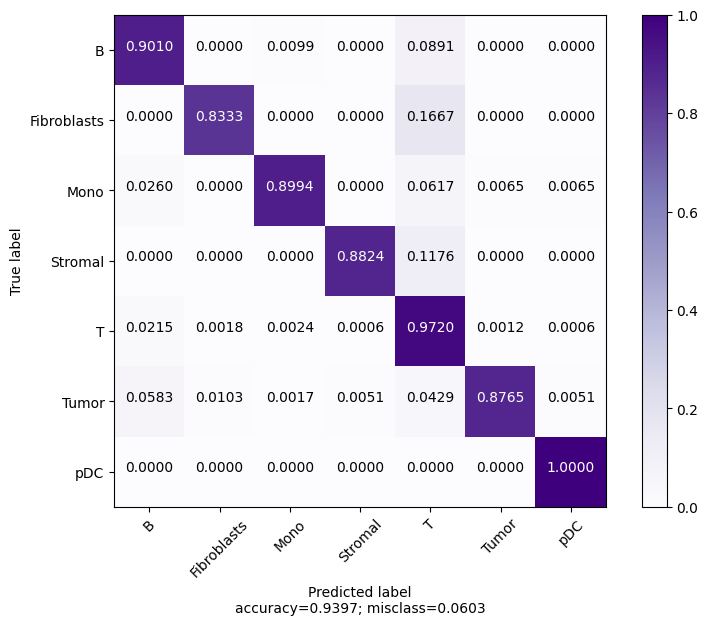

In [11]:
# Confusion matrix for performance with smallest alpha
scmkl.plot_conf_mat(results, normalize=True)

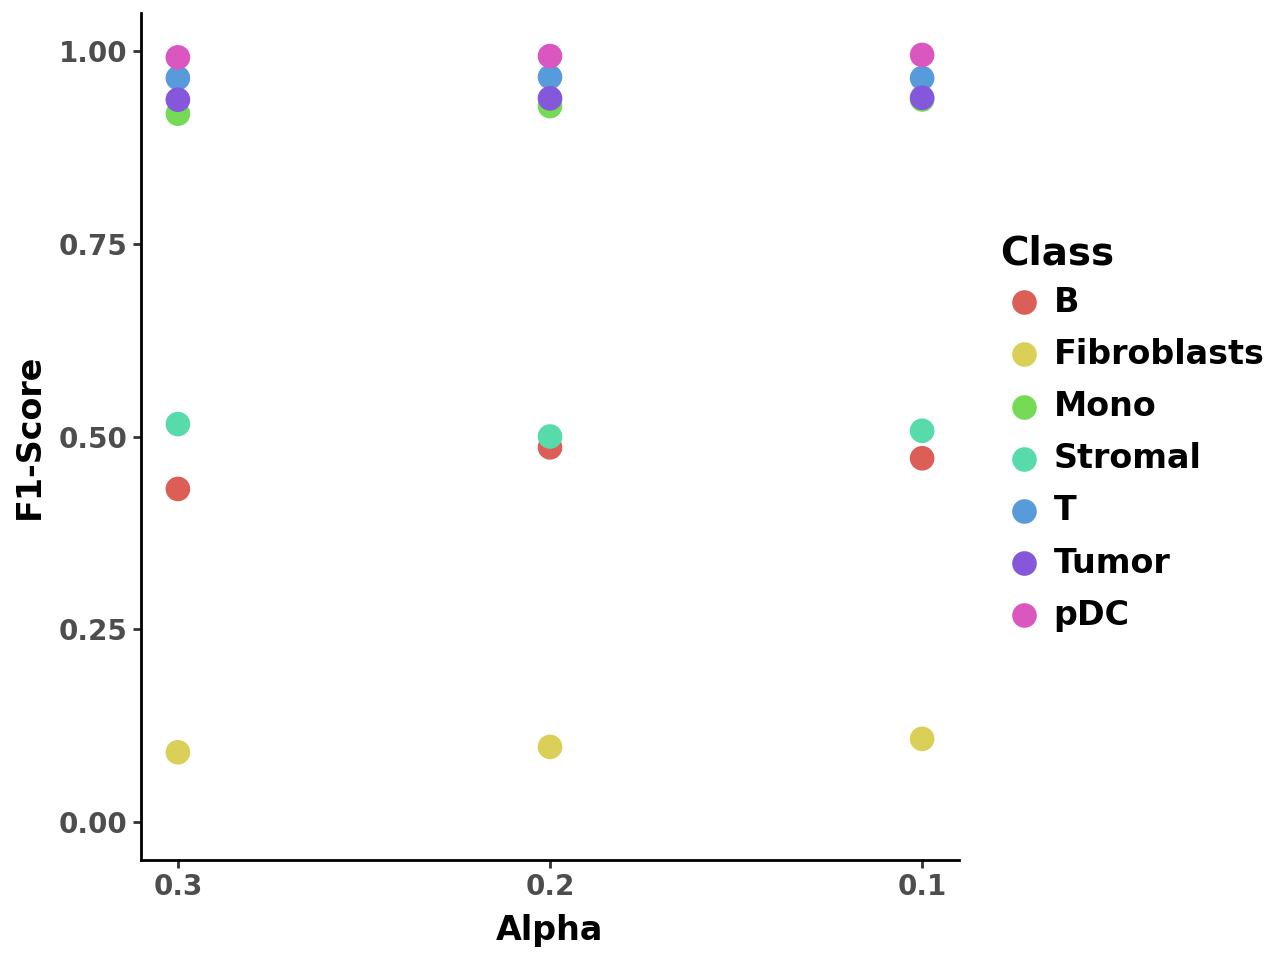

In [12]:
scmkl.plot_metric(summary)

## Interpretation

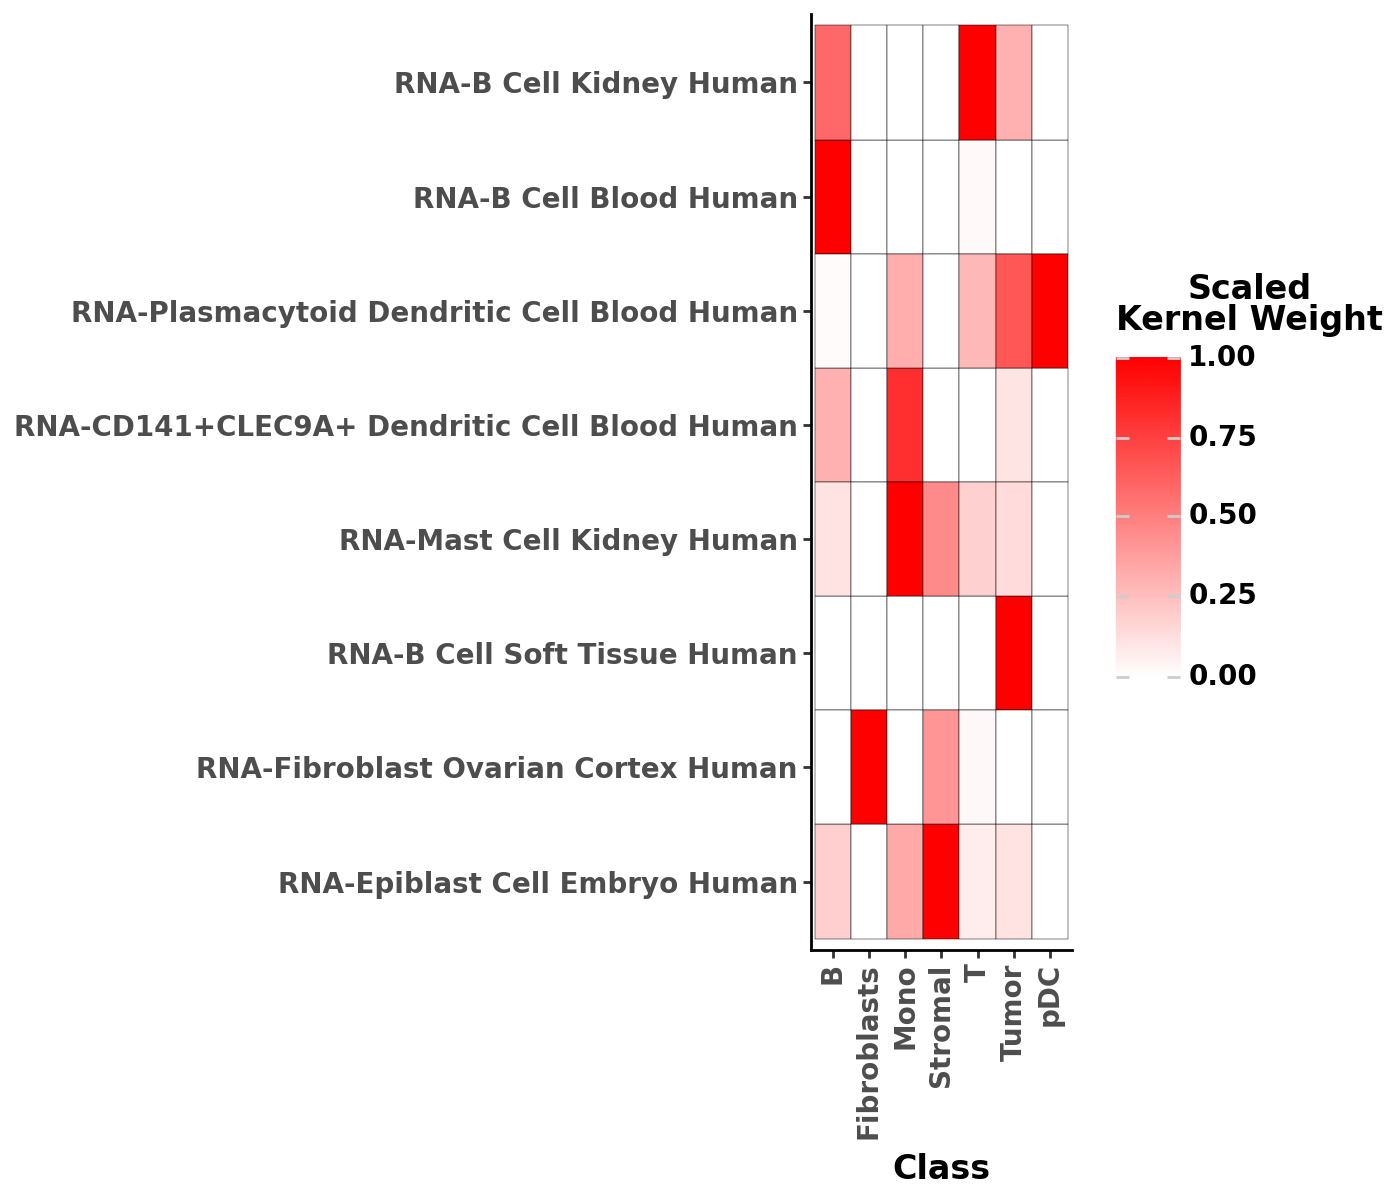

In [13]:
scmkl.weights_heatmap(results, n_groups=8, scale_weights=True)

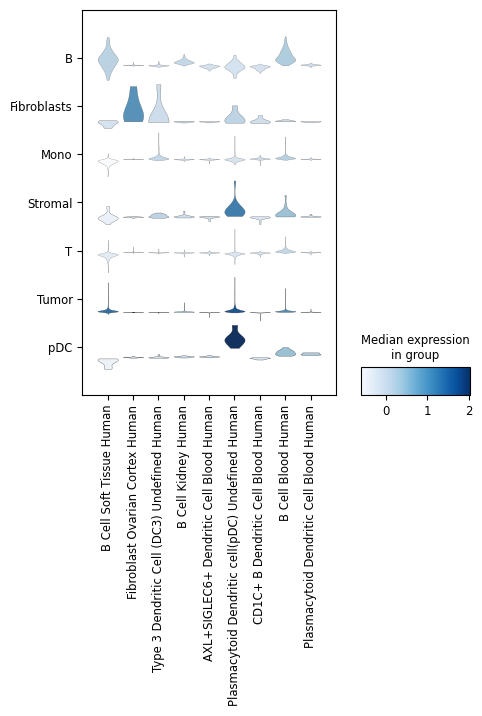

In [14]:
# Capturing top groups
top_groups = list({group[4:] for group in summary['Top Group'] if 'RNA' in group})

# adata with only test samples
test_adata = rna_adata[rna_adata.uns['test_indices']].copy()

# Calculating module scores for top groups
for group in top_groups:
    sc.tl.score_genes(test_adata, gene_groups[group], score_name=group)

sc.pl.stacked_violin(test_adata, top_groups, 'labels', figsize=(5,5))

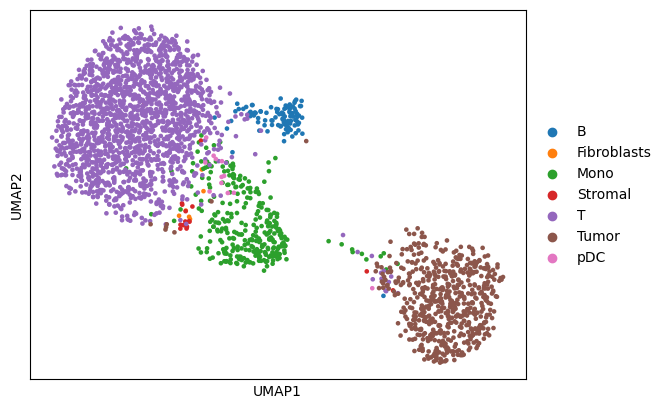

In [15]:
scmkl.group_umap(test_adata, top_groups)

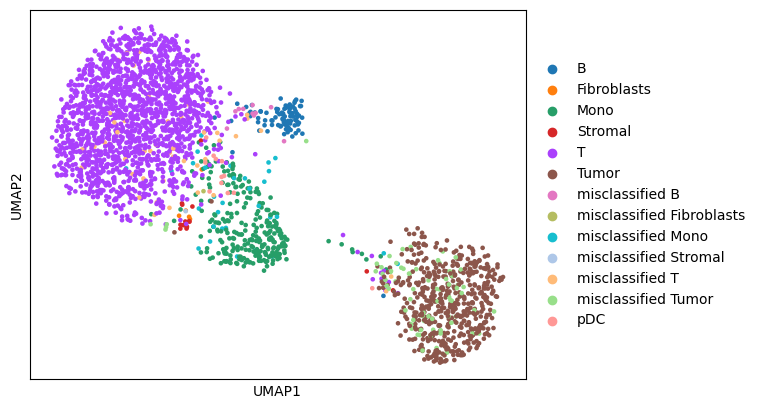

In [16]:
preds = np.array(results['Predicted_class'])
truth = np.array(results['Truth_labels'])
new_labs = list()

for i, pred in enumerate(preds):
    if pred != truth[i]:
        new_labs.append(f'misclassified {truth[i]}')
    else:
        new_labs.append(pred)

scmkl.group_umap(test_adata, top_groups, labels=new_labs)
